# A simple implementation of *The Cannon*
by **David W. Hogg** (Flatiron) for **Teresa Huang** (JHU) and **Soledad Villar** (JHU).

### Dependencies & Import Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive/Adversarial_Attack

/content/drive/My Drive/Adversarial_Attack


In [3]:
import pickle
import numpy as np
from scipy import optimize as op
import matplotlib.pyplot as plt
%matplotlib inline

RCOND = 1e-15
np.random.seed(17)

In [4]:
!pip install astropy
!pip install astroNN

In [5]:
from astroNN.datasets import H5Loader
from astroNN.apogee import aspcap_mask

# Load the training data
loader = H5Loader('__train_4k.h5')#H5Loader('__train_r_giant_1k_8575_1125_1557.h5')
loader.load_err = True
loader.target = ['teff', 'logg','Fe']
x_all,y_all,x_err,y_err = loader.load()

WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


/usr/local/lib/python3.6/dist-packages/astroNN/datasets/h5.py:580: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(self.h5path) as F:  # ensure the file will be cleaned up
/usr/local/lib/python3.6/dist-packages/astroNN/datasets/h5.py:612: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(self.h5path) as F:  # ensure the file will be cleaned up


In [6]:
x_err.shape, y_err.shape

((4175, 7514), (4175, 3))

In [7]:
good_idx = (y_all[:,0] > 3500) & (y_all[:,1] != -9999) & (y_all[:,2] > -1.0)
x = x_all[good_idx]
y = y_all[good_idx]
x_ivar = 1/x_err[good_idx]**2

In [8]:
x.shape, y.shape

((3975, 7514), (3975, 3))

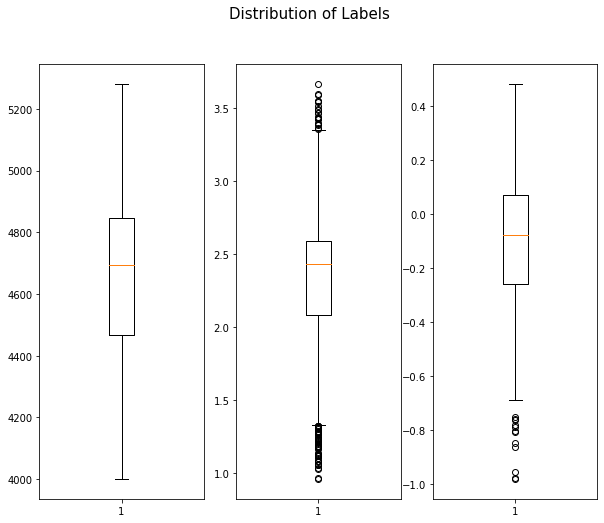

In [29]:
###Outliers
fig, axs = plt.subplots(ncols=3, figsize=(10,8))
for i in range(3):
  axs[i].boxplot(y[:,i])

fig.suptitle('Distribution of Labels', fontsize=15, y=0.98)
plt.show()

In [9]:
###train/test set
N = x.shape[0]
rs = np.random.uniform(size=N)
thre = 0.8
I_train = rs < thre
I_test = rs > thre
x_test = x[I_test]
y_test = y[I_test]
x_ivar_test = x_ivar[I_test]
xs = x[I_train]
ys = y[I_train]
x_ivars = x_ivar[I_train]

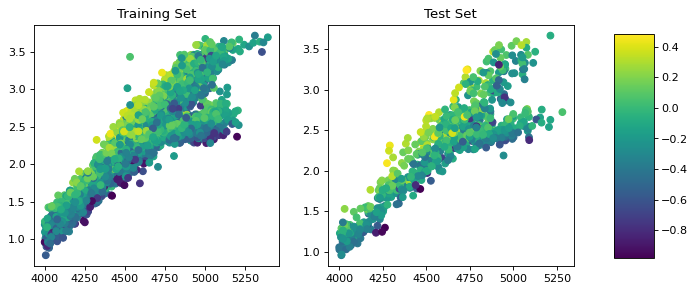

In [10]:
fig, axs = plt.subplots(ncols=2,figsize=(10,4), dpi=80)

for i, y in enumerate([ys, y_test]):
  im = axs[i].scatter(y[:,0], y[:,1], c=y[:,2])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

axs[0].set_title('Training Set')
axs[1].set_title('Test Set')
plt.show()

In [11]:
xs.shape, ys.shape, x_test.shape, y_test.shape, x_ivars.shape

((3222, 7514), (3222, 3), (753, 7514), (753, 3), (3222, 7514))

### TheCannon

In [12]:
#only the labels
def shifts_and_scales(labels):
  N, K = labels.shape
  foo = np.nanpercentile(labels, [2.5, 50., 97.5], axis=0)
  return foo[1], 0.5 * (foo[2] - foo[0])

shifts, scales = shifts_and_scales(ys)
whys = (ys - shifts) / scales

In [13]:
print(shifts, scales)
print(shifts_and_scales(whys))

[ 4.70473315e+03  2.43667245e+00 -9.62918736e-02] [5.23355817e+02 1.11536030e+00 4.75112199e-01]
(array([0., 0., 0.]), array([1., 1., 1.]))


In [14]:
def vectorize(why):
  K = len(why)
  v = np.array([1., ])
  v = np.append(v, why)
  v = np.append(v, np.outer(why, why)[np.triu_indices(K)])
  return v

def design_matrix(whys):
  return np.array([vectorize(why) for why in whys])

YY = design_matrix(whys)

In [15]:
print(YY.shape)

(3222, 10)


In [16]:
def train(xs, whys, x_ivars):
  """
  - Loop through each pixel/wavelength of xs, and fit: YY/sqrt(x_ivar) theta_perpixel = x/sqrt(x_ivar)
  - Return: theta, a stack of theta_perpixel, in shape (7514,10)
  """
  YY = design_matrix(whys)
  return np.array([np.linalg.lstsq(YY * np.sqrt(x_ivar)[:,None], x * np.sqrt(x_ivar), rcond=RCOND)[0] for x, x_ivar in zip(xs.T, x_ivars.T)])

theta = train(xs, whys, x_ivars)

In [17]:
print(theta.shape)

(7514, 10)


In [18]:
def test_objective(why, x, theta, x_ivar):
  """
  ## Bugs:
  - This should also return a gradient wrt input why.
  """
  resid = x - theta @ vectorize(why)
  return resid.T @ (resid * x_ivar)

def test_one(x, theta, x_ivar, K=3):
  """
  ## Bugs:
  - Only an idiot would use Nelder-Mead here.
  """
  why0 = np.zeros(K) # magic initialization
  result = op.minimize(test_objective, why0, args=(x, theta, x_ivar), method="Nelder-Mead") #JAX - numpy
  return result

def test_all(xs, theta, x_ivars, K=3):
  """
  Test all stars
  """
  return np.array([test_one(x, theta, x_ivar, K=K).x for x, x_ivar in zip(xs, x_ivars)])

ii = 17 # the most random number
result = test_one(x_test[ii], theta, x_ivar_test[ii])
print(result)
whystar = result.x
ystar = whystar * scales + shifts
print(ystar, y_test[ii])

 final_simplex: (array([[-0.21103331, -0.77674396, -0.22287418],
       [-0.21103121, -0.77673366, -0.22286525],
       [-0.21102358, -0.77673144, -0.22286462],
       [-0.21102786, -0.77673455, -0.22286989]]), array([1623932.33750737, 1623932.33754603, 1623932.33755866,
       1623932.33757955]))
           fun: 1623932.3375073653
       message: 'Optimization terminated successfully.'
          nfev: 257
           nit: 137
        status: 0
       success: True
             x: array([-0.21103331, -0.77674396, -0.22287418])
[ 4.59428764e+03  1.57032307e+00 -2.02182117e-01] [ 4.7005947e+03  2.4942818e+00 -2.4633667e-01]


In [19]:
why_stars = test_all(x_test, theta, x_ivar_test)
ystars = why_stars * scales + shifts

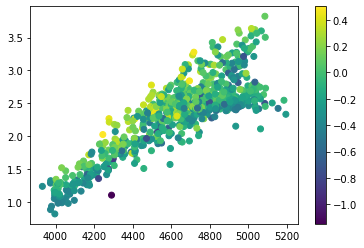

In [20]:
plt.scatter(ystars[:,0], ystars[:,1], c=ystars[:,2])
plt.colorbar()

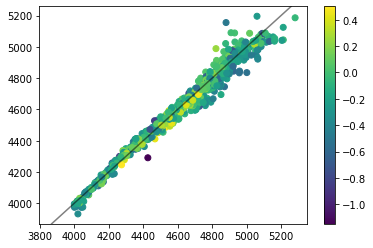

In [21]:
plt.scatter(y_test[:,0], ystars[:,0], c=ystars[:,2])
yy = plt.ylim()
plt.plot(yy, yy, 'k-', alpha=0.5)
plt.ylim(*yy)
plt.colorbar()

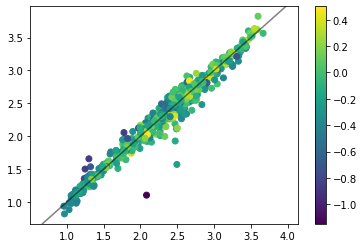

In [22]:
plt.scatter(y_test[:,1], ystars[:,1], c=ystars[:,2])
yy = plt.ylim()
plt.plot(yy, yy, 'k-', alpha=0.5)
plt.ylim(*yy)
plt.colorbar()

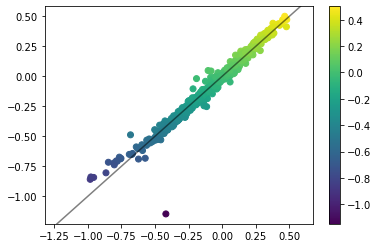

In [23]:
plt.scatter(y_test[:,2], ystars[:,2], c=ystars[:,2])
yy = plt.ylim()
plt.plot(yy, yy, 'k-', alpha=0.5)
plt.ylim(*yy)
plt.colorbar()